In [3]:
#https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE#dependencies_prerequisites
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K


input_shape = (50, 50, 3)
num_features = 7500#50*50*3
latent_dim = 25*25*3

In [4]:
def sampling(args):
    """Reparameterization trick. Instead of sampling from Q(z|X), 
    sample eps = N(0,I) z = z_mean + sqrt(var)*eps.

    Parameters:
    -----------
    args: list of Tensors
        Mean and log of variance of Q(z|X)

    Returns
    -------
    z: Tensor
        Sampled latent vector
    """

    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [5]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(50, 50, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

2022-04-13 18:18:48.955312: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def encoder_CNN(input_shape = (50, 50, 3), latent_dim = 2):

    inputs = layers.Input(shape=input_shape,name='Input')
    #block 1
    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False

    # block 2
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S4')(x)
    

    # block 3
    x = layers.Conv2D(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(16, (3, 3),
                    activation='relu',
                    padding='same',
                    name='block3_conv2')(x)    
                    
    x = layers.Conv2D(filters=3, kernel_size=5,strides=1,padding='same',name='output')(x)
    
    y = layers.Flatten()(x)
    #y = layers.Dense(latent_dim, activation ='relu',name='dense_layer')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(y)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(y)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var]) #reparametrization trick
    model = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    return model
    

In [7]:
encoder = encoder_CNN(latent_dim = latent_dim)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 50, 50, 64)   1792        ['Input[0][0]']                  
                                                                                                  
 block1_conv2 (Conv2D)          (None, 50, 50, 64)   36928       ['block1_conv1[1][0]']           
                                                                                                  
 block2_conv1 (Conv2D)          (None, 50, 50, 32)   18464       ['block1_conv2[1][0]']           
                                                                                            

In [8]:
def decoder_CNN( latent_dim = 2):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Reshape(target_shape=(25, 25, 3))(latent_inputs)
    x = layers.Conv2DTranspose(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block4_conv1')(x)
    x = layers.Conv2DTranspose(16, (3, 3),
                    activation='relu',
                    padding='same',
                    name='up_block4_conv2')(x)  

    # block 2
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv1')(x)
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv2')(x)
    x = layers.UpSampling2D()(x)
    
    
    x = layers.Conv2DTranspose(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block6_conv1')(x)
                      
    outputs = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation='relu',padding='same')(x)
   # outputs = layers.Reshape(target_shape=(50, 50, 3), name='output')(x)
    model = keras.Model(latent_inputs, outputs, name='decoder')
    return model

In [9]:
decoder = decoder_CNN(latent_dim = latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 1875)]            0         
                                                                 
 reshape (Reshape)           (None, 25, 25, 3)         0         
                                                                 
 up_block4_conv1 (Conv2DTran  (None, 25, 25, 16)       448       
 spose)                                                          
                                                                 
 up_block4_conv2 (Conv2DTran  (None, 25, 25, 16)       2320      
 spose)                                                          
                                                                 
 up_block5_conv1 (Conv2DTran  (None, 25, 25, 32)       4640      
 spose)                                                          
                                                           

In [10]:
def vae(input_shape, latent_dim, encoder, decoder):
    vae_input = layers.Input(shape = input_shape, name="VAE_input")

    encoder = encoder_CNN(latent_dim = latent_dim)
 

    decoder = decoder_CNN(latent_dim = latent_dim)
   

    vae = keras.Model(encoder.input, decoder(encoder.output[2]), name='VAE')
    return vae, encoder, decoder

In [11]:
vae, vae_encoder, vae_decoder = vae(input_shape, latent_dim, encoder, decoder)

In [12]:
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 50, 50, 64)   1792        ['Input[0][0]']                  
                                                                                                  
 block1_conv2 (Conv2D)          (None, 50, 50, 64)   36928       ['block1_conv1[2][0]']           
                                                                                                  
 block2_conv1 (Conv2D)          (None, 50, 50, 32)   18464       ['block1_conv2[2][0]']           
                                                                                                

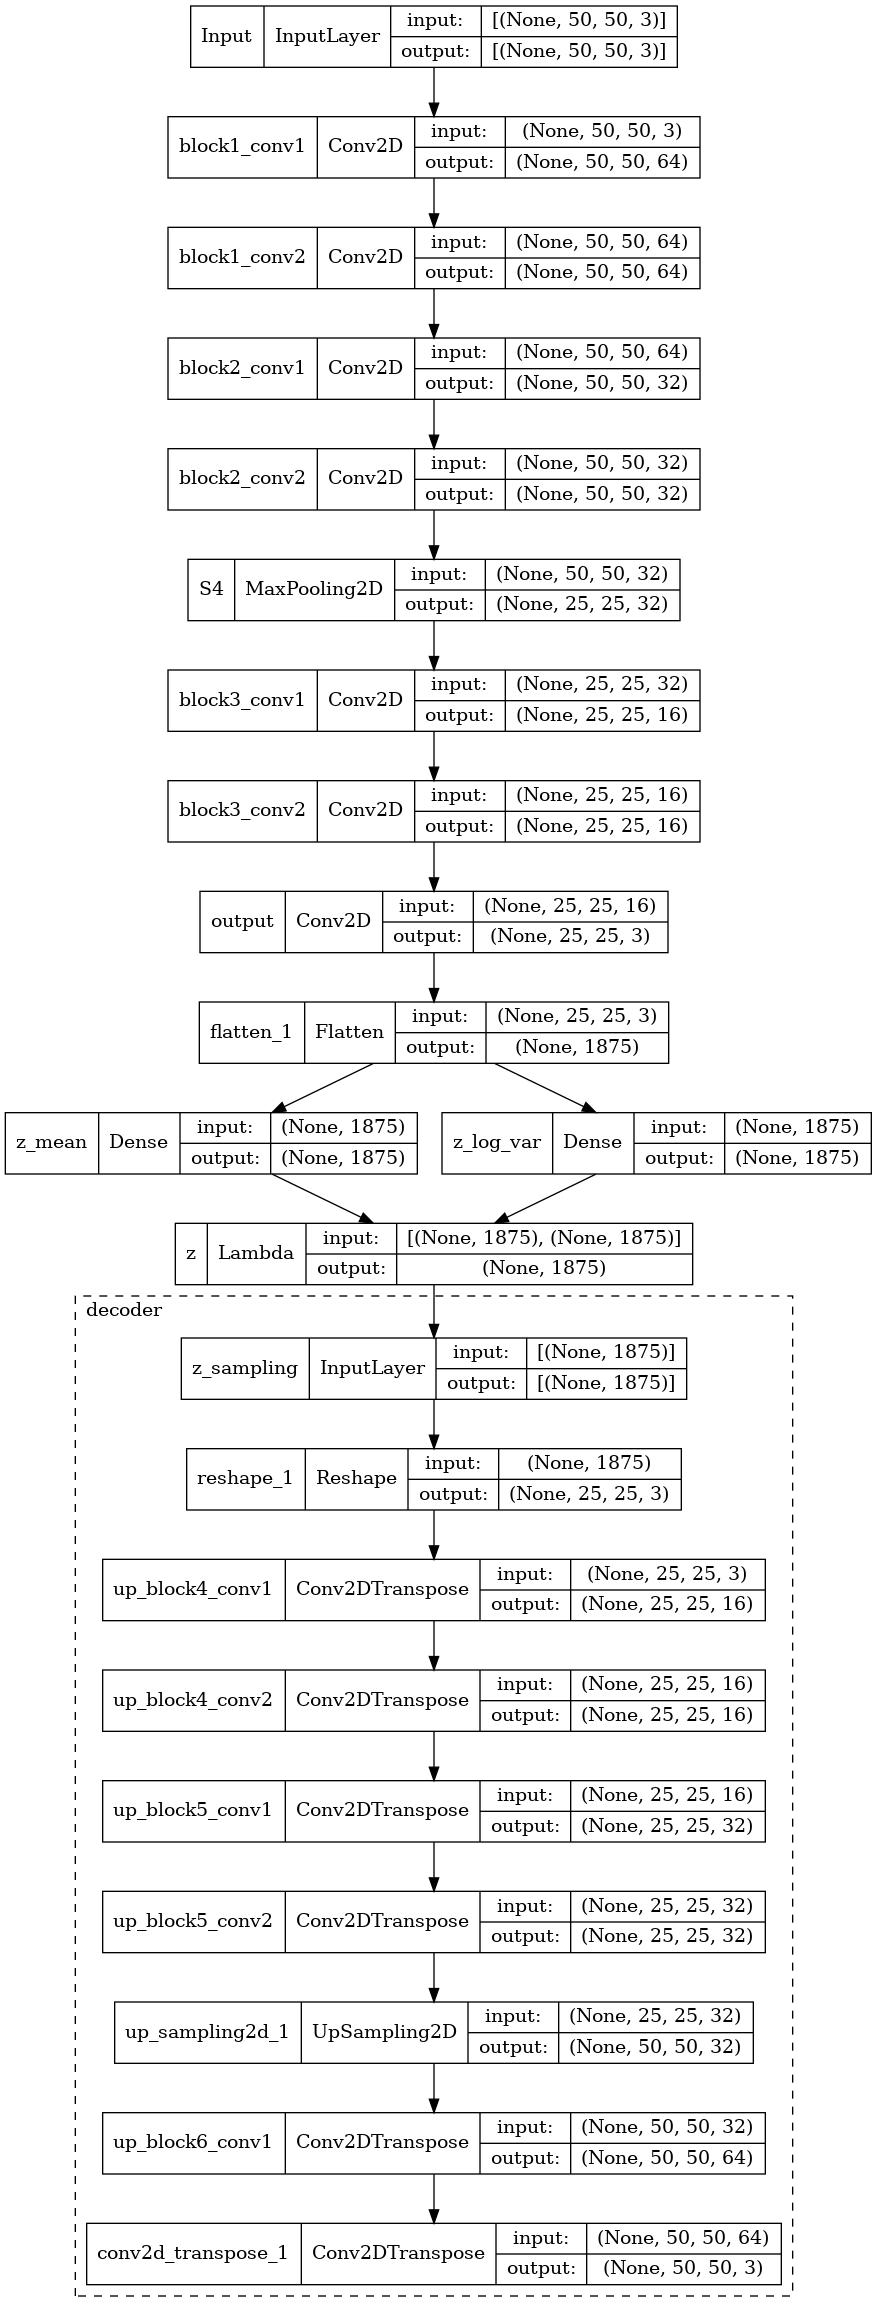

In [13]:
plot_model(vae,show_shapes=True, show_layer_names=True,expand_nested=True)

In [14]:
def vae_loss(encoder_mu, encoder_log_variance, beta_coefficient):

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1
        reconstruction_loss = K.mean(K.square(y_true - y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * K.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=[1, 2, 3])
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * K.backend.sum(1.0 + encoder_log_variance - K.square(encoder_mu) - K.exp(encoder_log_variance), axis=[1, 2, 3])
        return kl_loss

    def vae_loss(y_true, y_predict, beta_coefficient):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + beta_coefficient * kl_loss
        return loss

    return vae_loss

In [15]:
beta_coefficient=1

#Information needed to compute the loss function
vae_input = vae.input
vae_output = vae.output
mu = encoder.get_layer('z_mean').output
log_var= encoder.get_layer('z_log_var').output

vae.add_loss(vae_loss( mu, log_var, beta_coefficient))


In [16]:
vae.compile(optimizer='adam')

In [31]:
vae.save('models/vae.h5')  
encoder.save('models/vae_encoder.h5')
decoder.save('models/vae_decoder.h5')

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [24]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.MeanSquaredError(data, reconstruction), axis=(1, 2, 3) # mod
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [27]:
vae = VAE(encoder, decoder)

In [30]:
vae.compile(optimizer=keras.optimizers.Adam())
